# Monte Carlo estimator

In [1]:
using DataFrames
using CairoMakie
using AlgebraOfGraphics
using Distributions
using StatsBase

## $\pi$ estimation

\begin{equation}
\hat{\pi}_{MC} = 4 \frac{\text{\# points in the circle}}{\text{\# total points}}.
\end{equation}

In [2]:
# set radio and number of samples
r = 2
m = 5000
# simulate points coordinates
x = rand(Uniform(-2, 2), m)
y = rand(Uniform(-2, 2), m)
# compute distance with respect to the origin
distances = sqrt.(x .^ 2 + y .^ 2)
inside = distances .< r
# obtain pi estimate
4 * (sum(inside) / m)

3.156

Visualize the simulation

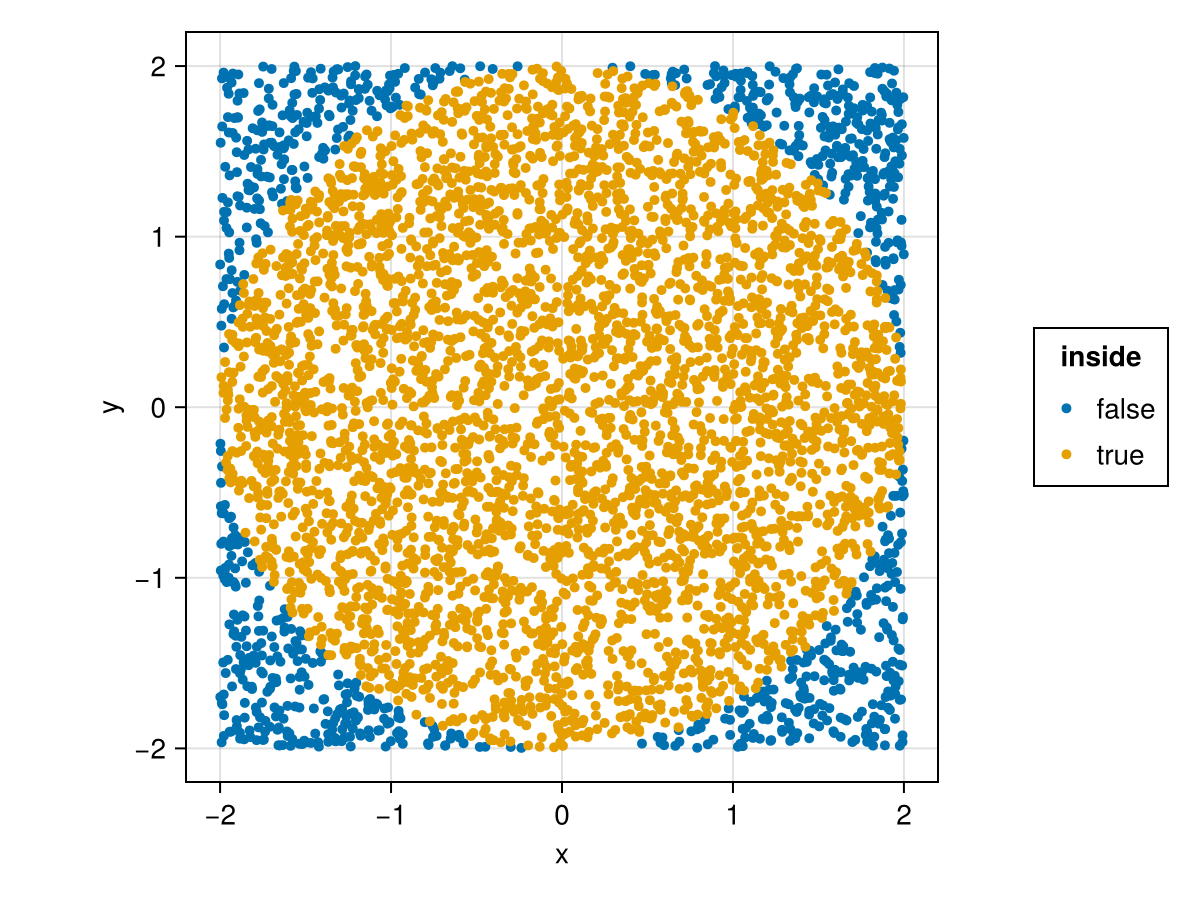

In [3]:
df = DataFrame(x = x, y = y, inside = inside)
g = data(df) * mapping(:x, :y, color = :inside) * visual(Scatter, markersize = 7)
fig = draw(g; axis = (aspect = DataAspect(),))

## Monte Carlo integration

In [4]:
using Distributions
using CairoMakie
using AlgebraOfGraphics
using DataFrames

### Mean estimate

In [5]:
# define the random variable
X = Exponential(100)
# obtain samples
m = 10000
xsamples = rand(X, m)
# aggregate results
estimate = sum(xsamples) / m
# variance
estimate_var = sum((xsamples .- estimate) .^ 2) / (m - 1) / m
println("Estimate: $(estimate) \nVariance of estimator: $(estimate_var)")

Estimate: 99.1844196952625 
Variance of estimator: 1.0147612836058562


What about $E[log(X)]$?

In [6]:
estimate2 = sum(log.(xsamples)) / m
estimate2_var = sum((log.(xsamples) .- estimate2) .^ 2) / (m - 1) / m
println("Estimate: $(estimate) \nVariance of estimator: $(estimate_var)")

Estimate: 99.1844196952625 
Variance of estimator: 1.0147612836058562


We can also check the error trend

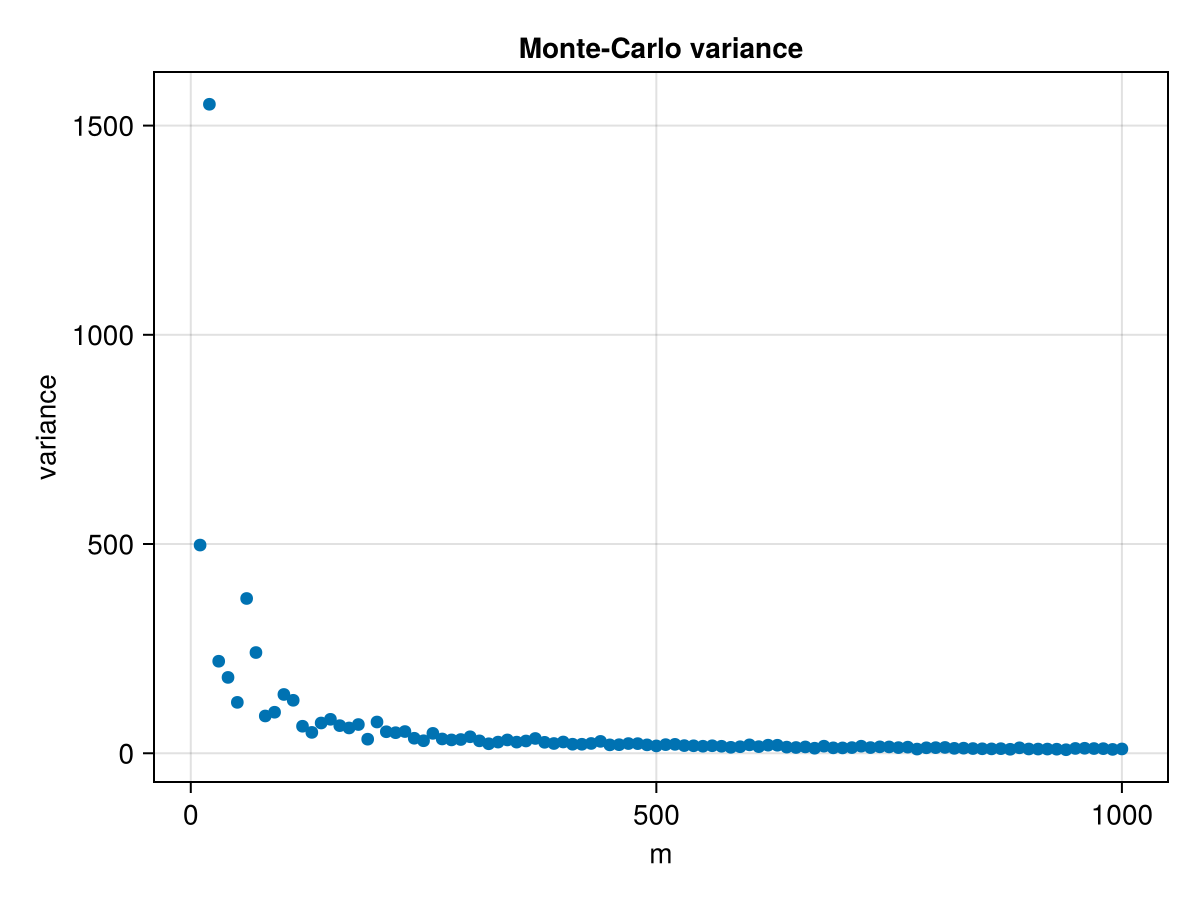

In [7]:
function mcvar(X, m)
    xsamples = rand(X, m)
    estimate = sum(xsamples) / m
    estimate_var = sum((xsamples .- estimate) .^ 2) / (m - 1) / m
end

mseq = 10:10:1000
varseq = mcvar.(Exponential(100), mseq)
fig = scatter(mseq, varseq, markersize = 9,
    axis = (title = "Monte-Carlo variance", xlabel = "m", ylabel = "variance"))

## Importance resampling algorithm

In this section, we simulate realization for random variables where the density function
is known up to a constant of proportionality $\pi(x) = kJ(x)$.

In [8]:
using CairoMakie
using Distributions
using StatsBase

### Beta example

\begin{align*}
  f(x) & = \frac{1}{B(\alpha, \beta)}x^{\alpha-1}(1-x)^{\beta-1} ~~\text{for}~~ 0\leq
  x\leq 1 \\
  & \propto x^{\alpha-1}(1-x)^{\beta-1} = J(x).
\end{align*}

#### Set parameters and J

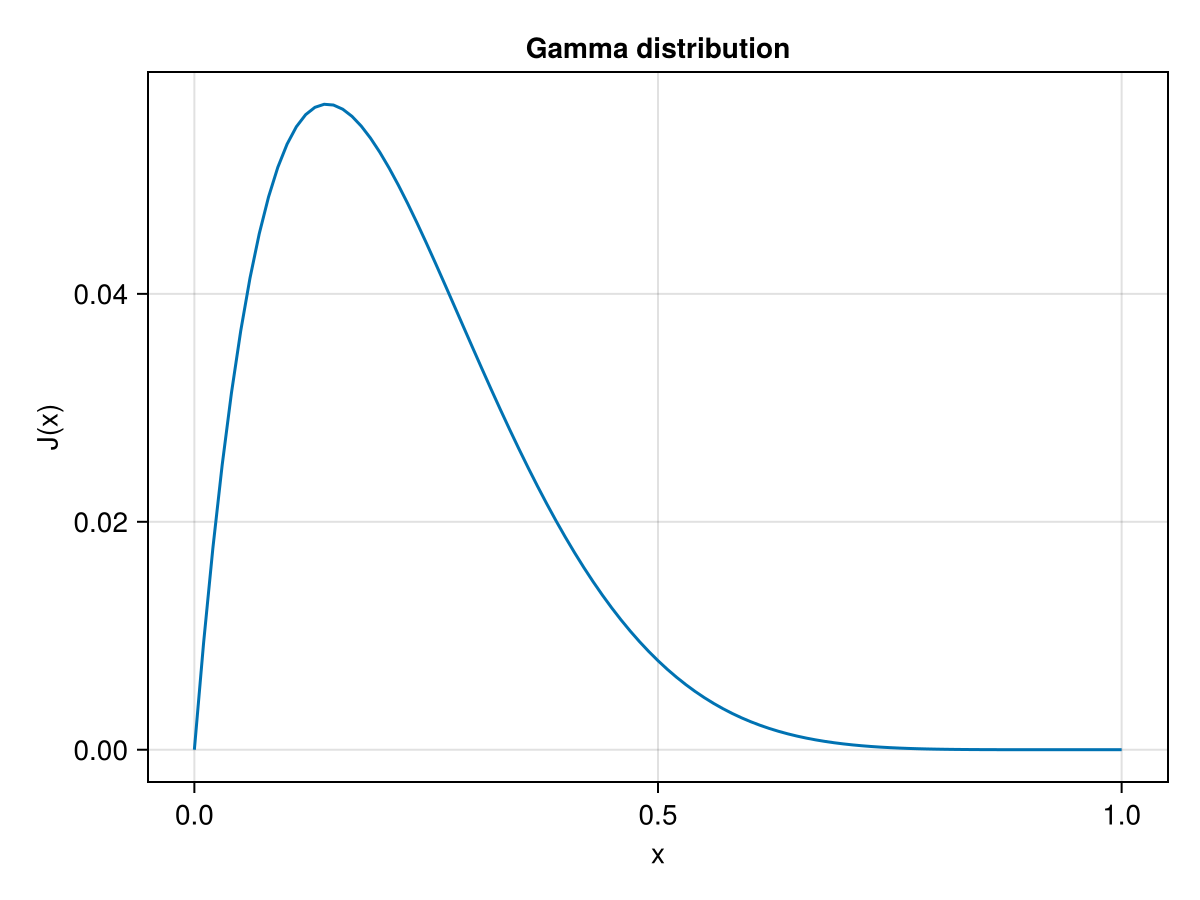

In [9]:
α = 2
β = 7
J(x) = x^(α-1) * (1-x)^(β-1)
fig = lines(0:0.01:1, J.(0:0.01:1),
    axis = (title =  "Gamma distribution", xlabel = "x", ylabel = "J(x)")
)

#### SIR

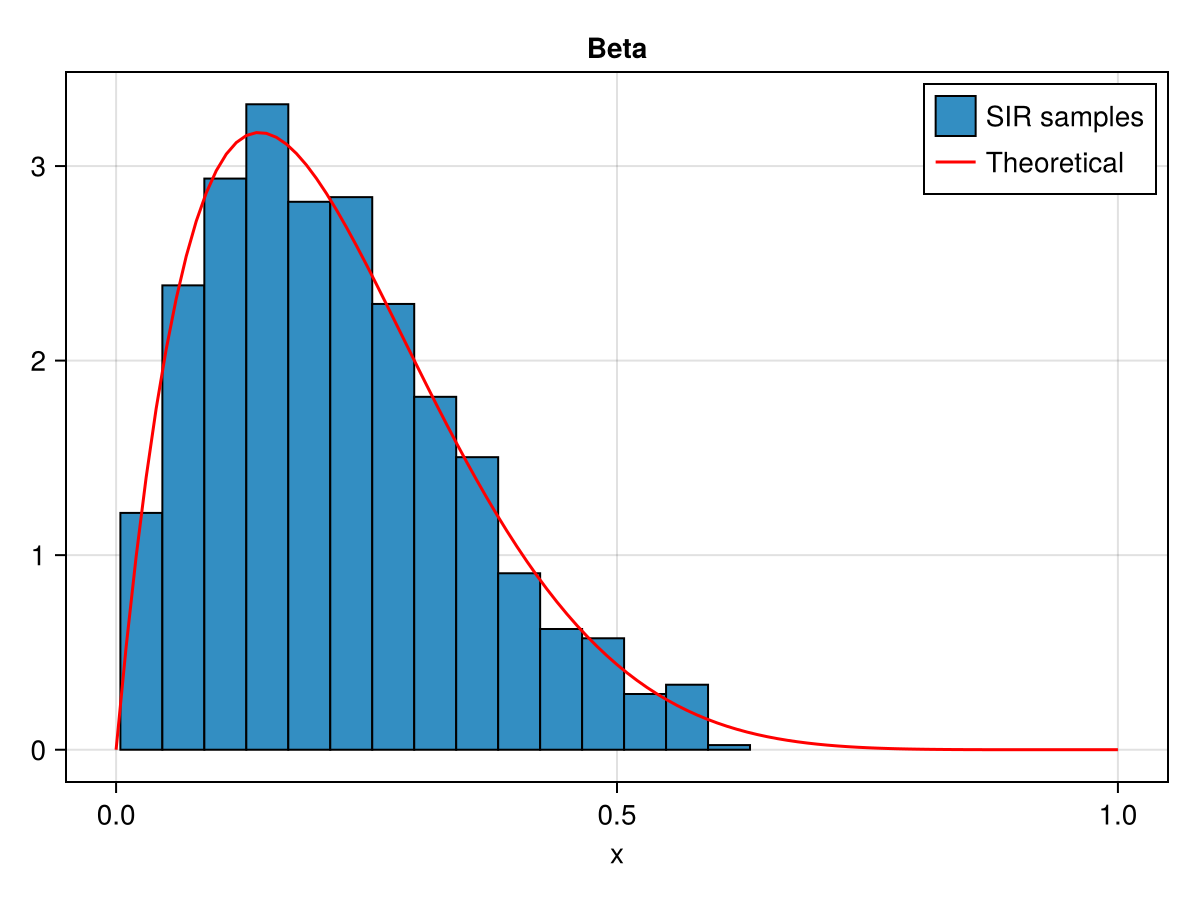

In [10]:
# set up n and m
n = 10000
m = 1000
# simulate from q()
y = rand(n)
# obtain the weights
yw = J.(y) ./ pdf.(Uniform(0,1), y)
yw_st = yw ./ sum(yw)
# resample from y
xsample = sample(y, Weights(yw_st), m)

# visualize
fig = hist(xsample, strokewidth = 1, normalization = :pdf, axis = (xlabel = "x", title = "Beta"), label = "SIR samples")
lines!(0:0.01:1, pdf.(Beta(α, β), 0:0.01:1), color = :red, label = "Theoretical")
axislegend()
fig

## Tail density estimation

In [11]:
using Distributions
using CairoMakie
using AlgebraOfGraphics
using DataFrames

### Implemented value

In [12]:
cdf(Normal(), -4.5)

3.3976731247300518e-6

In [13]:
logcdf(Normal(), -4.5)

-12.59241973571308

### Monte Carlo

In [14]:
m = 100000
f = Normal()
xsamples = rand(f, m)
mean(xsamples .> 4.5)

0.0

### Monte Carlo with importance sampling

In [15]:
m = 100000
f = Normal()
g = truncated(Exponential(1), lower = 4.5)
xsamples = rand(g, m)
gx = exp.(logpdf(f, xsamples) - logpdf(g, xsamples))
mean(gx)

3.3764980257214105e-6

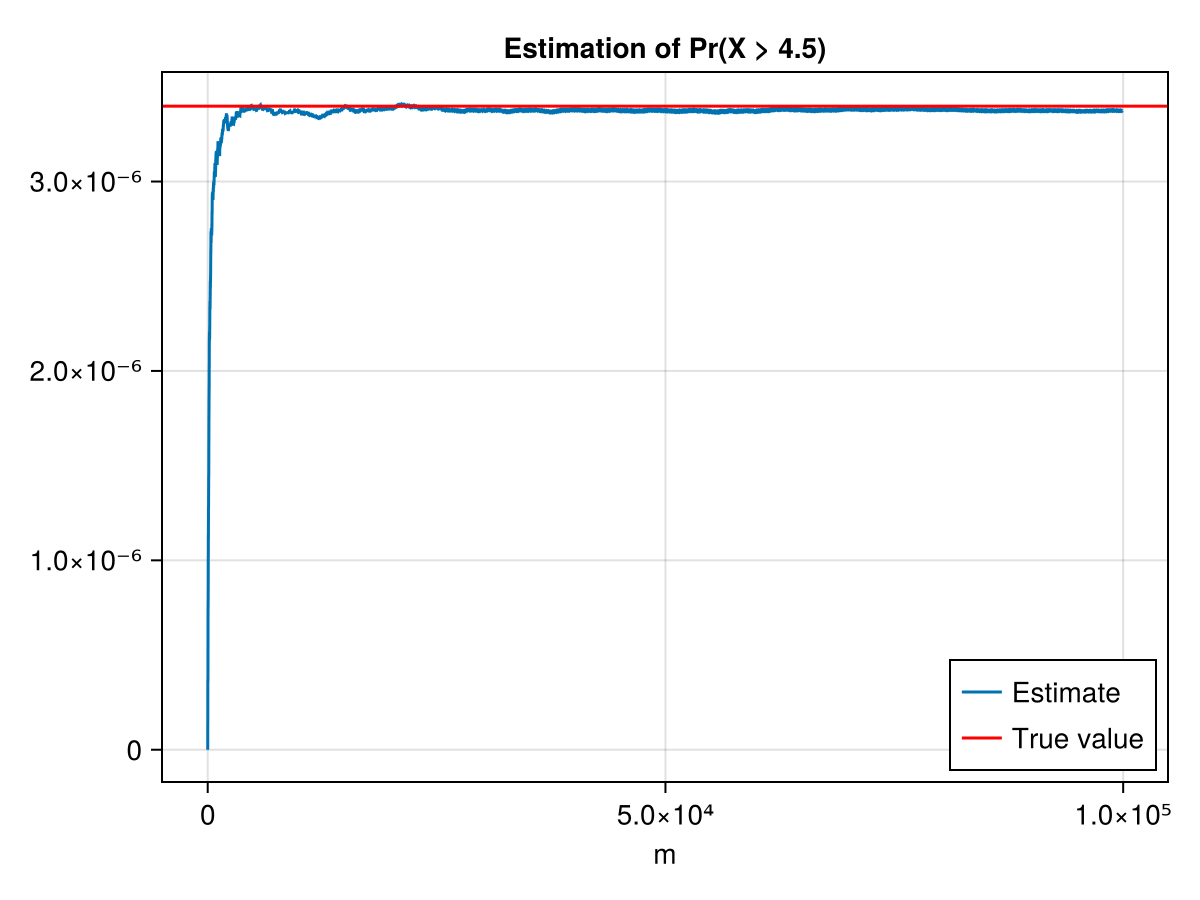

In [16]:
axis_args = (xlabel = "m", title = "Estimation of Pr(X > 4.5)")
lines(cumsum(gx[100:m]) ./ (100:m), label = "Estimate", axis = axis_args)
hlines!([cdf(Normal(), -4.5)], label = "True value", color = :red)
axislegend(position = :rb)
CairoMakie.current_figure()

## Tail density estimation

In [17]:
using Distributions
using CairoMakie
using AlgebraOfGraphics
using DataFrames

### MC convergence (Normal)

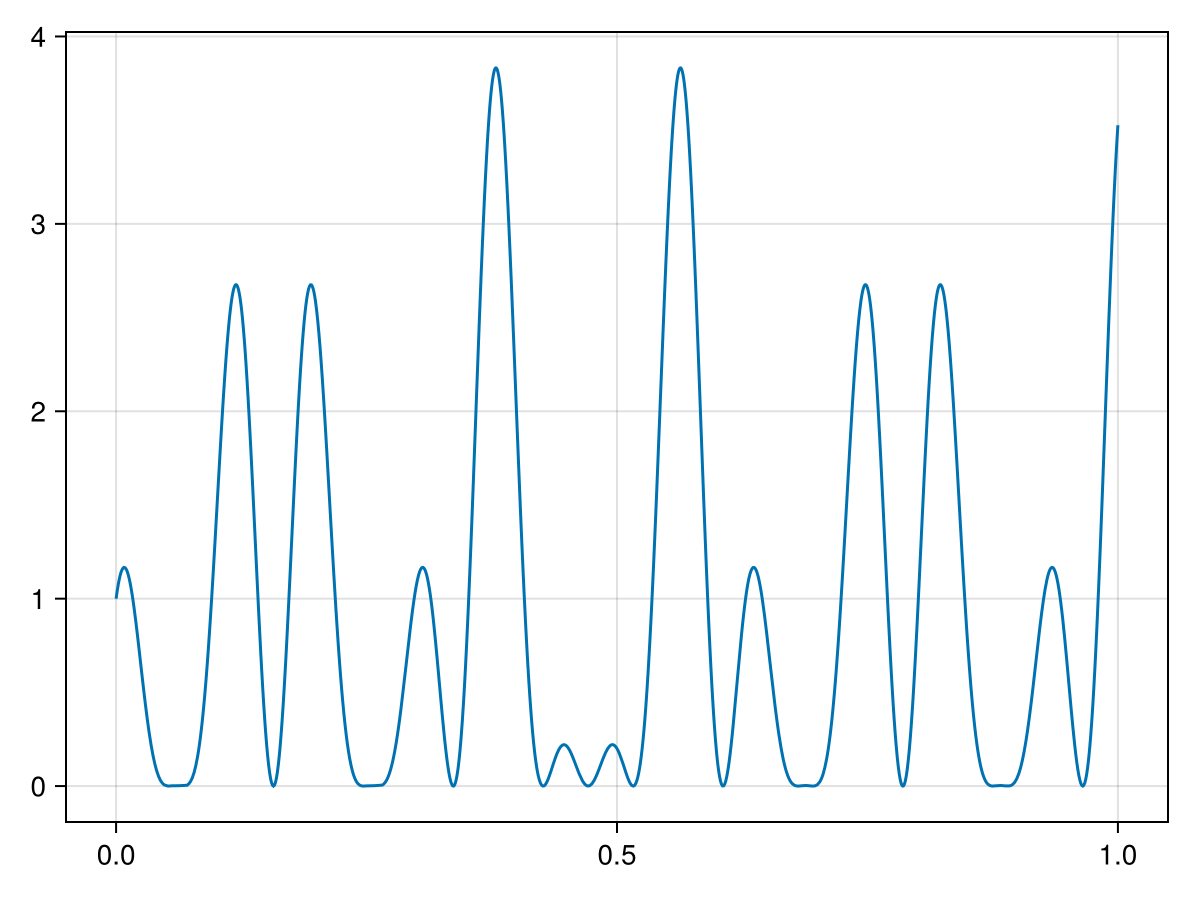

In [18]:
h(x) = (cos(50x) + sin(20x))^2
lines(0..1, h)

In [19]:
m = 10^4
hx = h.(rand(m))
mean(hx)

0.9675904749262693

In [20]:
est = cumsum(hx) ./ (1:m)
esterr = sqrt.(cumsum((hx - est) .^ 2)) ./ (1:m)

10000-element Vector{Float64}:
 0.0
 0.4419741456110907
 0.29759317154877624
 0.23970396941940122
 0.3671180074638019
 0.33464845188327796
 0.31304861720667104
 0.27808553252372453
 0.24722376454619052
 0.22308365812406783
 ⋮
 0.010466978849415194
 0.010466376234096941
 0.010467162253434407
 0.010466488424803662
 0.010467586497230936
 0.010466939745936973
 0.010466337194227734
 0.010465567744381562
 0.010467221924929812

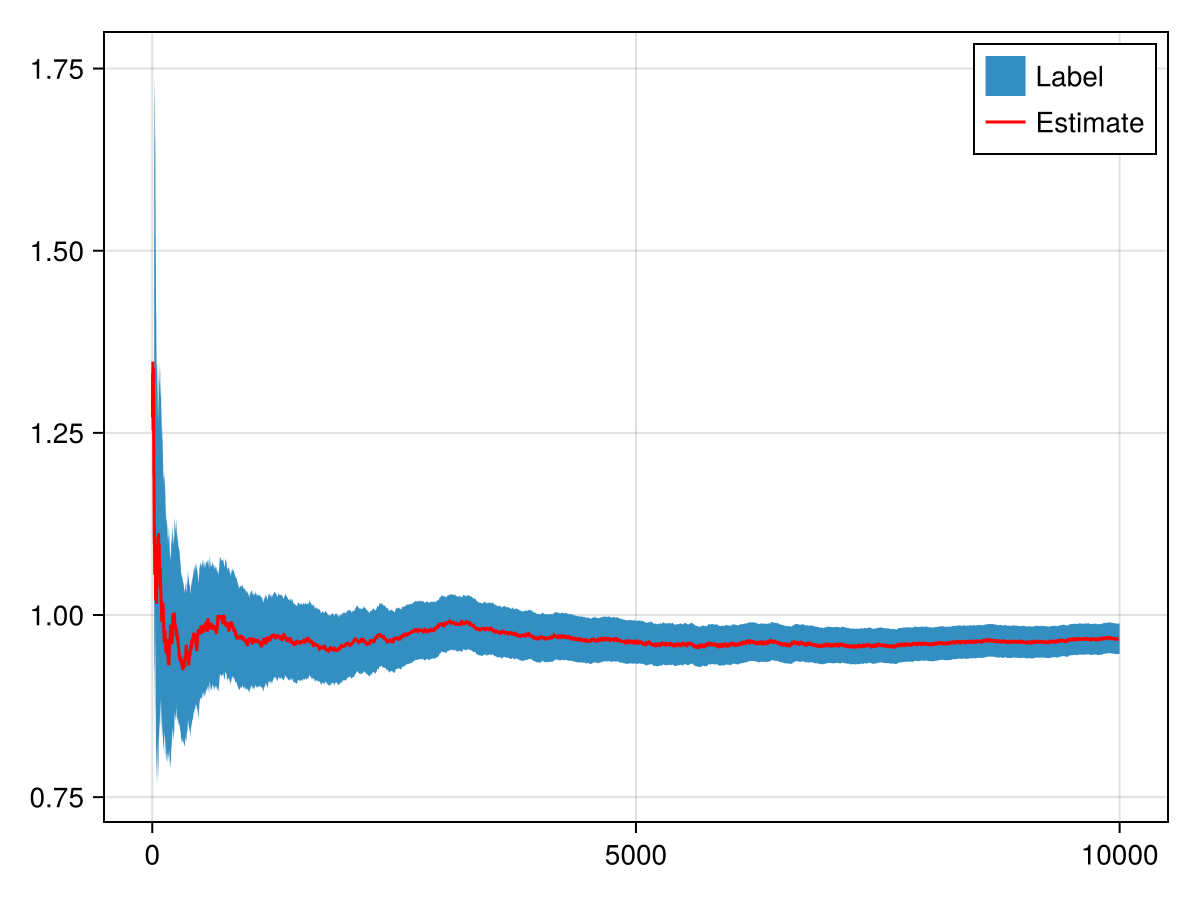

In [21]:
band(20:m, (est - 2 * esterr)[20:m], (est + 2 * esterr)[20:m], label = "Label")
lines!(cumsum(hx)[20:m] ./ (20:m), color = :red, label = "Estimate")
axislegend()
CairoMakie.current_figure()

### MC convergence (adequate)

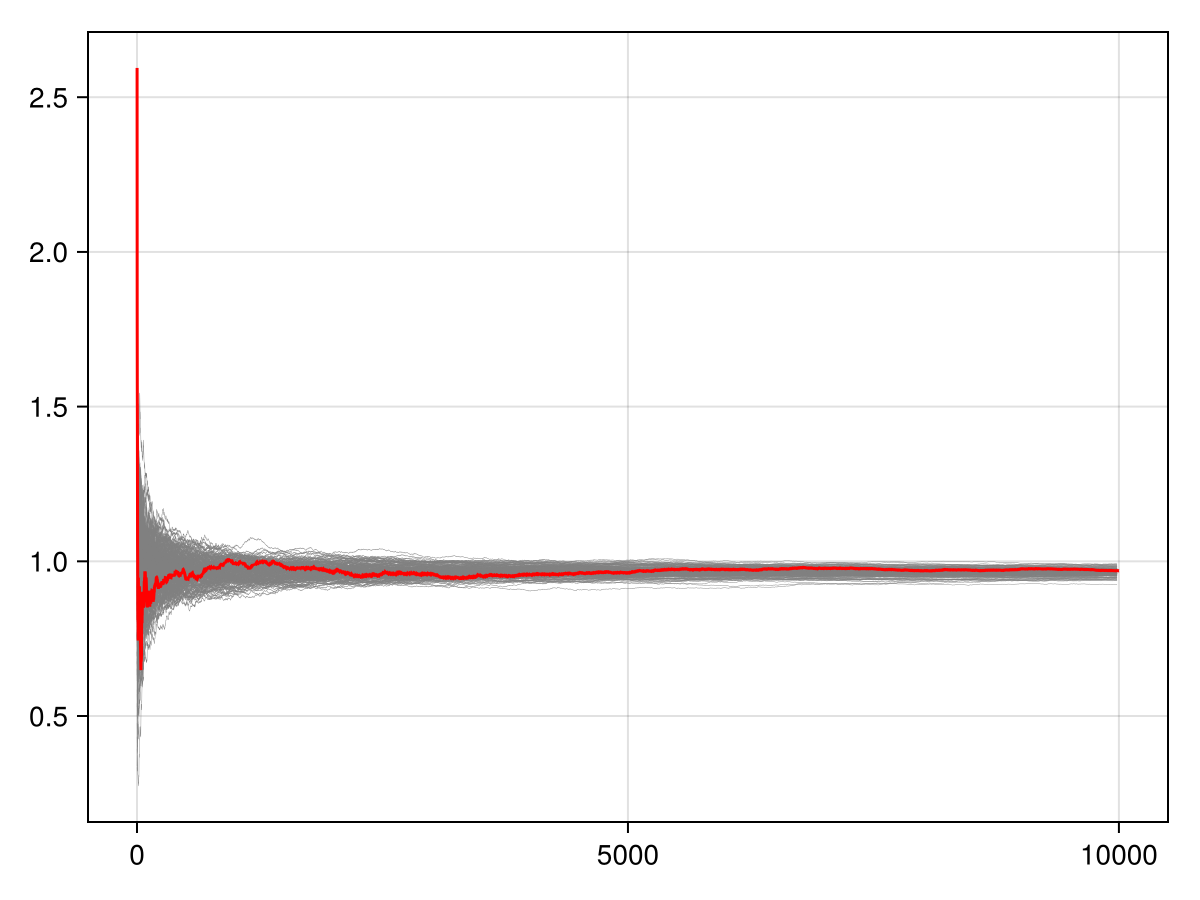

In [22]:
est = cumsum(h.(rand(200, m)), dims = 2) ./ reshape(repeat(1:m, inner = 200), 200, m)

series(est[:, 20:m], solid_color = :gray, linewidth = 0.2)
lines!(est[1,:], color = :red)
CairoMakie.current_figure()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*